In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
df = pd.read_csv('fraud_payment_data', sep=',', header=0) 
df

In [ ]:
#Converting time into a Datetime object
df['timestamp'] = pd.to_datetime(df['Time_step'])
#Removing redudant columns
df=df.drop('Time_step',axis=1)
df=df.drop('Sender_lob',axis=1)
df=df.drop('Sender_Sector',axis=1)
#Apparently some transactions amounted to zero dollars. None of them were fraudulent, so I've removed them.
df=df[df.USD_amount>0]
df

In [45]:
#Last_Digit=pd.DataFrame(columns=['Digit'])
#for index,row in train_data.iterrows():
#    Last_Digit.loc[index]=(row.USD_amount*100)%10
Last_Digit2=pd.DataFrame(columns=['Digit'])
for index,row in train_data.iterrows():
    Last_Digit2.loc[index]=(np.floor(row.USD_amount))%10

<Axes: >

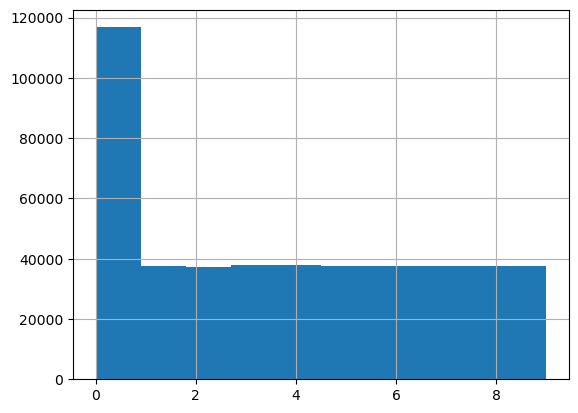

In [51]:
dig=pd.concat([train_data,Last_Digit2],axis=1)
dig[dig.Label==0]['Digit'].hist()

<Axes: >

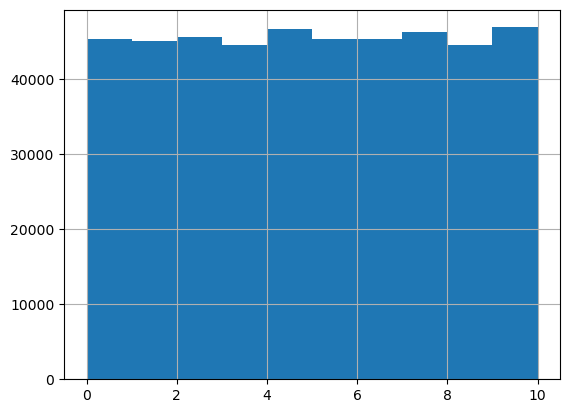

In [41]:
dig=pd.concat([train_data,Last_Digit],axis=1)
dig[dig.Label==0]['Digit'].hist()


In [21]:
Digit=pd.DataFrame(columns=['Last_Digit','First Digit'])
for index,row in train_data.iterrows():
    value=[0,0]
    if (row.USD_amount*200)%10==0:
        value[0]=1
    if str(row.USD_amount)[0]=='5':
        value[1]=1
    Digit.loc[index]=value
Digit

,Last_Digit,First Digit
0,0,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
465003,0,0
465004,1,0
465005,0,0
465006,0,0


In [23]:
Digit.to_csv('Digit_features', index=False)

In [ ]:
#Splitting data into approximately first ten years for training and the next 20 years for testing.
train_data=df[0:465000]
test_data=df[465001:-1]
train_data

In [79]:
#Used to model the probability distribution of amount spent/recieved in a transaction given a historical average.
#Returns probability of the transaction amount being greater than or equal to the one observed
from scipy.stats import expon
def amount_prob(mean,amount):
    return 1-expon.cdf(x=amount, scale=mean)

In [81]:
## Function that takes as input a node (an account), and a graph of transactions, and outputs the smallest  
## number of transactions seperating the account from an account that had previously been involved in fraud. 
## The number of transactions is counted in the forward direction (outgoing transactions), and been restricted to at maximum length 10.
## If greater than 10, then just return a huge value so the corresponding feature has a negligent value.
def min_path_to_fraud(sender_node,G):
    reach=nx.single_source_shortest_path_length(G, sender_node, cutoff=10)
    Fraud_nodes=[node for node in reach.keys() if G.nodes[node]['Fraud_count']>0]
    shortest_lengths = [reach[node] for node in Fraud_nodes]

    if shortest_lengths:
        return min(shortest_lengths)
    else:
        return 100000000 

## An alternative measure of connectedness to the above. This measures what percentage of the nodes within 10 
## transactions of the given node are historically involved in fraud.
def fraud_centrality(node,G):
    reach=nx.single_source_shortest_path_length(G, node, cutoff=10).keys()
    return len([node for node in reach if G.nodes[node]['Fraud_count']>0])/len(reach)


In [17]:
##Initiate graph
G = nx.MultiDiGraph()

##Initiate features we aim to engineer
##bene/sender_prob is the probability explained above, Fraud_percentage_bene/sender is the percentage of fraudulent transactions among all transactions (ingoing and outgoing) the sender account has been involved in, and Fraud_index_bene/sender is the distance given by the min_path function above.
features_in= pd.DataFrame(columns=['bene_prob','Fraud_percentage_bene','Fraud_index_bene'])
features_out= pd.DataFrame(columns=['sender_prob','Fraud_percentage_sender','Fraud_index_sender'])

##Repeat is whether a transaction with the same sender and beneficiary has occurred. Quick represents whether the transaction is a Quick payment transaction type.
feature=pd.DataFrame(columns=["Repeat","Quick"])
for index, row in train_data.iterrows():
    if index%1000==0:
       print(index)
    
    ## First build features related to sender accounts (features_out)
    if G.has_node(row['Sender_Account']): ## If node already exists (i.e sender account involved in some transaction before)  
      if G.out_degree(row['Sender_Account'])>0: ## If node has been involved in an outgoing transaction
        ##Engineer sender account features 
        features_out.loc[index]=[amount_prob(G.nodes[row['Sender_Account']]['total_out']/G.out_degree(row['Sender_Account']),row['USD_amount']),G.nodes[row['Sender_Account']]['Fraud_count']/(G.out_degree(row['Sender_Account'])+G.in_degree(row['Sender_Account'])),1/(1+min_path_to_fraud(row['Sender_Account'],G))]
        #features_out.loc[index]=[amount_prob(G.nodes[row['Sender_Account']]['total_out']/G.out_degree(row['Sender_Account']),row['USD_amount']),G.nodes[row['Sender_Account']]['Fraud_count']/(G.out_degree(row['Sender_Account'])+G.in_degree(row['Sender_Account'])),fraud_centrality(row['Sender_Account'],G)]
        #The line above is an alternate engineering where the fraud_centrality feature is built instead of the min_path. Not run yet.     
      else:
        ##Engineer sender account features with default value for the prob feature as zero if no outgoing transaction history.
        features_out.loc[index]=[0,G.nodes[row['Sender_Account']]['Fraud_count']/(G.out_degree(row['Sender_Account'])+G.in_degree(row['Sender_Account'])),1/(1+min_path_to_fraud(row['Sender_Account'],G))]          
        #features_out.loc[index]=[0,G.nodes[row['Sender_Account']]['Fraud_count']/(G.out_degree(row['Sender_Account'])+G.in_degree(row['Sender_Account'])),fraud_centrality(row['Sender_Account'],G)]
        #The line above is an alternate engineering where the fraud_centrality feature is built instead of the min_path. Not run yet.          
      #Update graph
      G.nodes[row['Sender_Account']]['total_out']+=row['USD_amount']
      G.nodes[row['Sender_Account']]['Fraud_count']+=row['Label']   
    else:##If node does not exist, create node and attributes
      if row.Sender_Account!='NaN':
        G.add_node(row['Sender_Account'], country=row['Sender_Country'], Id=row['Sender_Id'], total_out=row['USD_amount'], total_in=0, Fraud_count=row['Label'])
      features_out.loc[index]=[0,0,0]
    if row.Bene_Account=='NaN':##If the transaction is a self-transaction, update both total_in and total_out
        G.nodes[row['Sender_Account']]['total_in']+=row['USD_amount']
    
    
    ##Repeat the same for beneficiary account
    if G.has_node(row['Bene_Account']):
      if G.in_degree(row['Bene_Account'])>0:
        features_in.loc[index]=[amount_prob(G.nodes[row['Bene_Account']]['total_in']/G.in_degree(row['Bene_Account']),row['USD_amount']),G.nodes[row['Bene_Account']]['Fraud_count']/(G.out_degree(row['Bene_Account'])+G.in_degree(row['Bene_Account'])),1/(1+min_path_to_fraud(row['Bene_Account'],G))]
        #features_in.loc[index]=[amount_prob(G.nodes[row['Bene_Account']]['total_in']/G.in_degree(row['Bene_Account']),row['USD_amount']),G.nodes[row['Bene_Account']]['Fraud_count']/(G.out_degree(row['Bene_Account'])+G.in_degree(row['Bene_Account'])),fraud_centrality(row['Bene_Account'],G)]      
      else:
        features_in.loc[index]=[0,G.nodes[row['Bene_Account']]['Fraud_count']/(G.out_degree(row['Bene_Account'])+G.in_degree(row['Bene_Account'])),1/(1+min_path_to_fraud(row['Bene_Account'],G))]          
        #features_in.loc[index]=[0,G.nodes[row['Bene_Account']]['Fraud_count']/(G.out_degree(row['Bene_Account'])+G.in_degree(row['Bene_Account'])),fraud_centrality(row['Bene_Account'],G)]                     
      G.nodes[row['Bene_Account']]['total_in']+=row['USD_amount']
      G.nodes[row['Bene_Account']]['Fraud_count']+=row['Label']
    else:
      if row.Bene_Account!='NaN':
        G.add_node(row['Bene_Account'], country=row['Bene_Country'],Id=row['Bene_Id'], total_out=0, total_in=row['USD_amount'],Fraud_count=row['Label'])
      features_in.loc[index]=[0,0,0]   
    if row.Sender_Account=='NaN':
        G.nodes[row['Bene_Account']]['total_out']+=row['USD_amount']
    
               
    ##Engineer the other features
    feature.loc[index]=[G.has_edge('Sender_Account','Bene_Account'),row['Transaction_Type']=='QUICK-PAYMENT']
    ##I eventually replaced the Repeat feature above in another file and generated the opposite 'New' feature, 
    ##and another feature 'Repeat_Fraud' that checks additionally if the repeated transaction was fraudulent. 
    ##Code below that can be easily appended to this.
    
    ###new= not(G.has_edge(row['Sender_Account'],row['Bene_Account']))
    ###repeatfraud=(not new) and repeat_fraud(G,row['Sender_Account'],row['Bene_Account'])
    ###feature.loc[index]=[new,repeatfraud]
    
    ##Add edges and attributes in the graph corresponding to the transaction
    if row['Sender_Account']=='NaN':
      G.add_edge(row['Bene_Account'], row['Bene_Account'], amount=row['USD_amount'], time=row['timestamp'], Type=row['Transaction_Type'],label=row['Label'], Id=row['Transaction_Id'])
    if row['Bene_Account']=='NaN':
      G.add_edge(row['Sender_Account'], row['Sender_Account'], amount=row['USD_amount'], time=row['timestamp'], Type=row['Transaction_Type'],label=row['Label'], Id=row['Transaction_Id'])
    else:
      G.add_edge(row['Sender_Account'], row['Bene_Account'], amount=row['USD_amount'], time=row['timestamp'], Type=row['Transaction_Type'],label=row['Label'], Id=row['Transaction_Id'])
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [21]:
##Concatenate all features into one final dataframe
final=pd.concat([features_in,features_out,feature],axis=1)
final

,bene_prob,Fraud_percentage_bene,Fraud_index_bene,sender_prob,Fraud_percentage_sender,Fraud_index_sender,Repeat,Quick
0,0.000000,0.0000,0.000000e+00,0.000000,0.0,0.000000e+00,False,False
1,0.000000,0.0000,0.000000e+00,0.000000,0.0,0.000000e+00,False,True
2,0.000000,0.0000,0.000000e+00,0.000000,0.0,1.000000e-08,False,False
3,0.000000,0.0000,0.000000e+00,0.000000,0.0,0.000000e+00,False,False
4,0.000000,0.0000,0.000000e+00,0.375175,0.0,1.000000e-08,False,False
...,...,...,...,...,...,...,...,...
465003,0.566662,0.0213,1.000000e+00,0.541099,0.0,5.000000e-01,False,False
465004,0.330606,0.0000,5.000000e-01,0.270565,0.0,3.333333e-01,False,True
465005,0.285493,0.0213,1.000000e+00,0.319239,0.0,5.000000e-01,False,False
465006,0.006415,0.0000,1.000000e-08,0.729414,0.0,5.000000e-01,False,False


In [47]:
##Save dataframe as .csv file
final.to_csv('features_10', index=False)

,bene_prob,Fraud_percentage_bene,Fraud_index_bene,sender_prob,Fraud_percentage_sender,Fraud_index_sender,Repeat,Quick
0,0.000000,0.0000,0.000000e+00,0.000000,0.0,0.000000e+00,False,False
1,0.000000,0.0000,0.000000e+00,0.000000,0.0,0.000000e+00,False,True
2,0.000000,0.0000,0.000000e+00,0.000000,0.0,1.000000e-08,False,False
3,0.000000,0.0000,0.000000e+00,0.000000,0.0,0.000000e+00,False,False
4,0.000000,0.0000,0.000000e+00,0.375175,0.0,1.000000e-08,False,False
...,...,...,...,...,...,...,...,...
465003,0.566662,0.0213,1.000000e+00,0.541099,0.0,5.000000e-01,False,False
465004,0.330606,0.0000,5.000000e-01,0.270565,0.0,3.333333e-01,False,True
465005,0.285493,0.0213,1.000000e+00,0.319239,0.0,5.000000e-01,False,False
465006,0.006415,0.0000,1.000000e-08,0.729414,0.0,5.000000e-01,False,False


In [27]:
##Save graph as a .pickle file
import pickle
with open('Graph_10.pickle', 'wb') as f:
    pickle.dump(G, f)


In [ ]:
# Load the graph
    with open('my_graph.pickle', 'rb') as f:
        loaded_G = pickle.load(f)